In [219]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

In [320]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_train = 'train_videos'
# test_video = 'ASL_2006_10_10_scene2-camera1_AGAIN_v0_9.mov' # good
# test_video = 'ASL_2008_01_11_scene9-camera1_AGAIN_v0_0.mov' # good
# test_video = 'ASL_2008_05_12a_scene8-camera1_AGAIN_v0_2.mov' # bad
# test_video = 'ASL_2008_08_04_scene7-camera1_AGAIN_v0_4.mov' # bad
test_video = 'ASL_2008_08_04_scene8-camera1_ALL_v0_2.mov' # bad
# test_video = 'ASL_2011_06_08_Brady_scene33-camera1_DEPOSIT_v0_4.mov'
cap = cv2.VideoCapture(os.path.join(project_path, dir_train, test_video))

CONTRAST_ALPHA = 1
FEATURE_MIN_DIST = 5

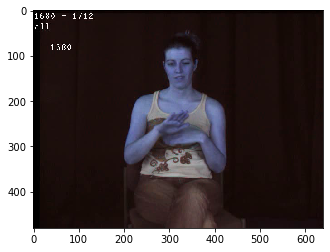

In [321]:
ret, first_frame = cap.read()
plt.imshow(first_frame)

In [322]:
first_frame_copy = first_frame.copy()
first_frame.shape

(480, 640, 3)

[[281  86  80  80]]


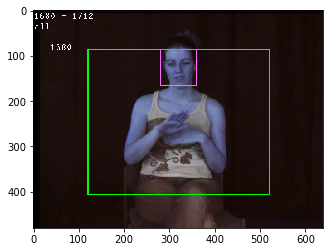

(<matplotlib.image.AxesImage at 0x25ac11d66c8>, None)

In [323]:
# Reference for this cell: https://docs.opencv.org/4.0.0-beta/d4/d8c/tutorial_py_shi_tomasi.html
face_cascade = cv2.CascadeClassifier(r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\haarcascade_frontalface_default.xml')
face = face_cascade.detectMultiScale(first_frame_copy, scaleFactor=1.3 , minNeighbors=7)
print(face)
for (x,y,w,h) in face:
    cv2.rectangle(first_frame_copy, (x,y), (x+w, y+h), (255,100,255),2)
    cv2.rectangle(first_frame_copy, (x-w*2,y), (x+w*3, y+h*4), (0,255,0),2)
    crop_x0 = x-w*2
    crop_x1 = x+w*3
    crop_y0 = y
    crop_y1 = y+h*4
    break
plt.imshow(first_frame_copy),plt.show()

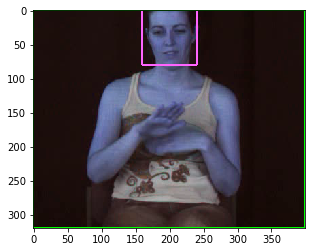

(<matplotlib.image.AxesImage at 0x25abffe64c8>, None)

In [324]:
first_frame_crop = first_frame_copy[crop_y0:crop_y1, crop_x0:crop_x1]
plt.imshow(first_frame_crop),plt.show()

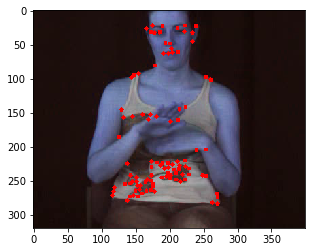

(<matplotlib.image.AxesImage at 0x25ac00d7f48>, None)

In [325]:
# Reference for cv2.goodFeaturesToTrack: https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=goodfeaturestotrack
first_frame = first_frame[crop_y0:crop_y1, crop_x0:crop_x1]
first_frame = cv2.convertScaleAbs(first_frame, alpha=CONTRAST_ALPHA, beta=0)
prev_gray = cv2.cvtColor(first_frame,cv2.COLOR_BGR2GRAY)
prev_corners = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100,qualityLevel=0.01,minDistance=FEATURE_MIN_DIST)
prev_corners_int = np.int0(prev_corners)
# Plot the good features to track
for i in prev_corners_int:
    x,y = i.ravel()
    cv2.circle(first_frame,(x,y),3,255,-1)
        
plt.imshow(first_frame),plt.show()

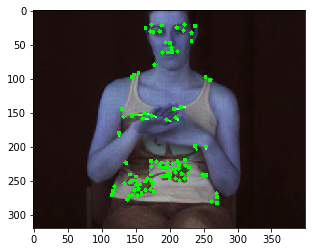

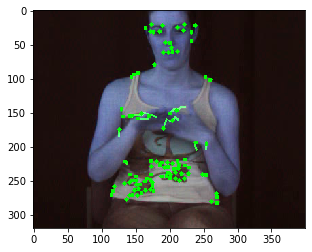

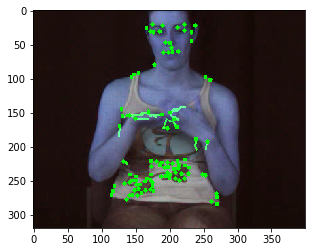

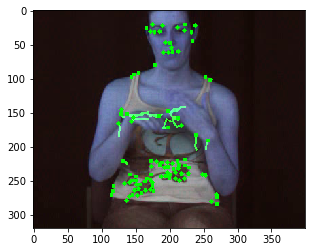

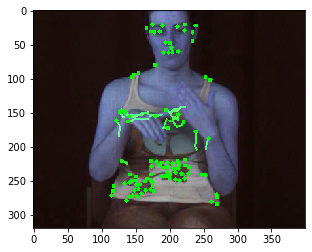

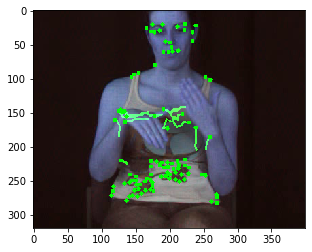

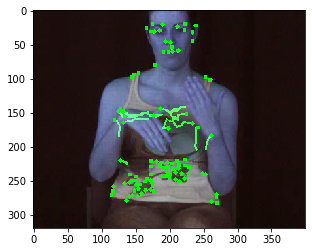

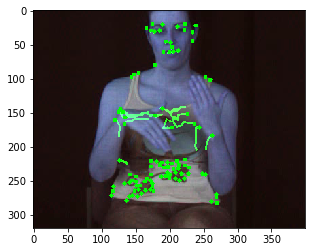

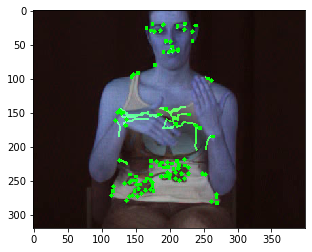

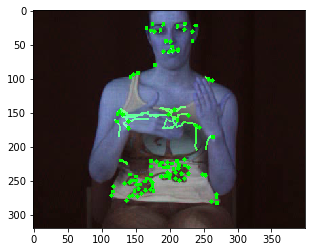

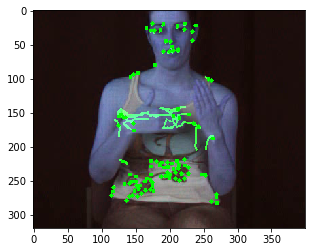

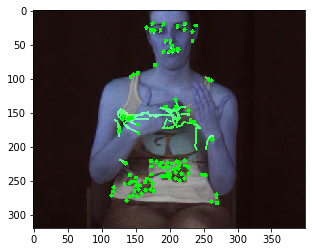

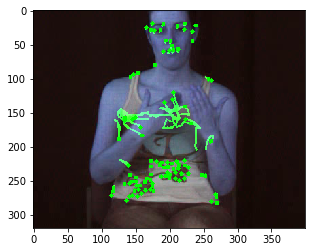

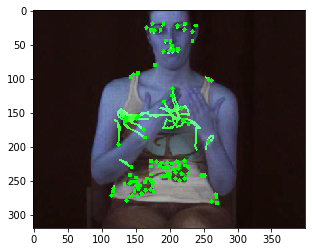

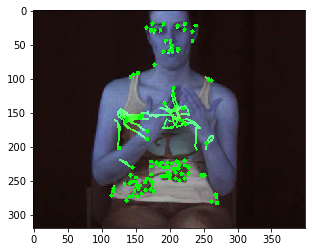

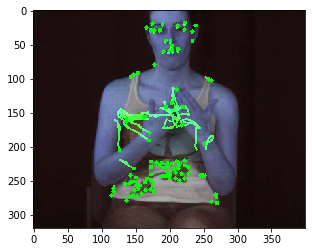

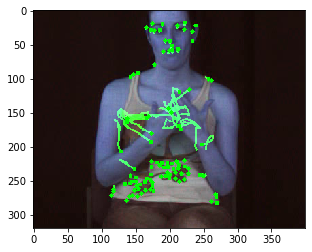

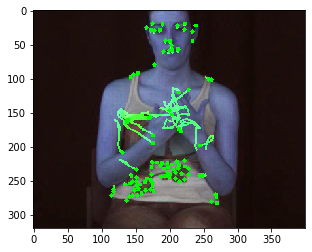

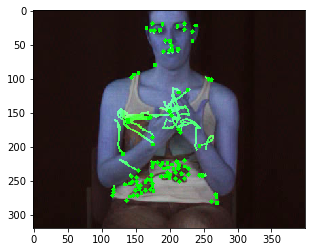

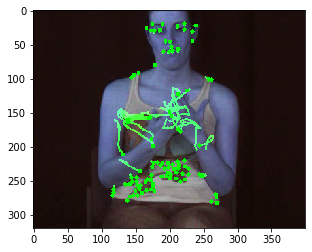

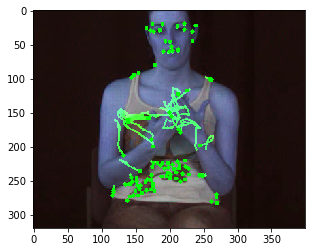

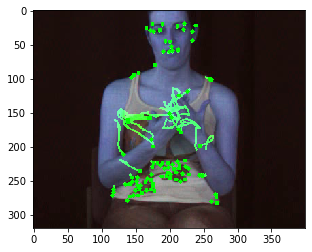

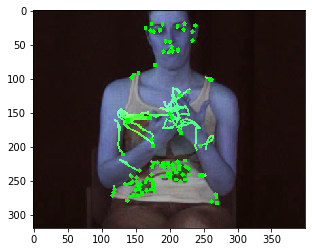

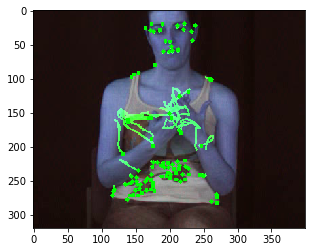

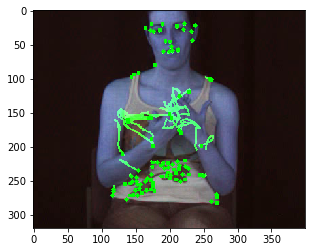

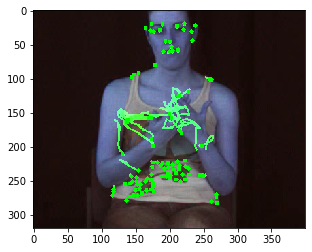

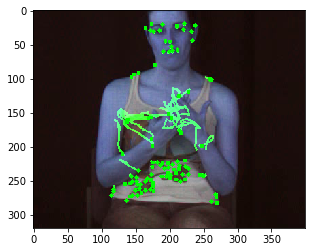

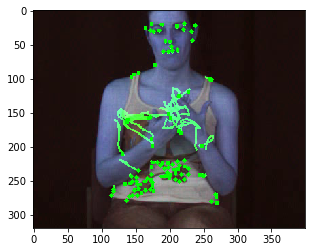

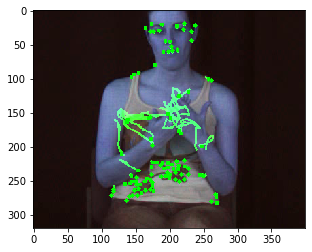

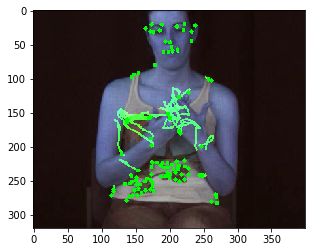

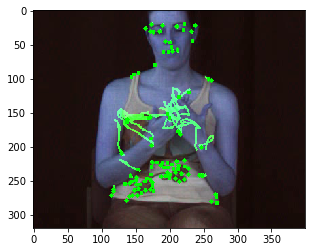

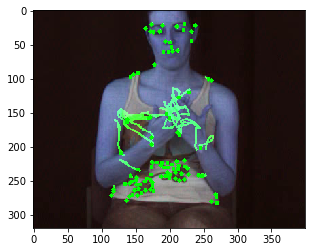

In [326]:
mask = np.zeros_like(first_frame)
# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (25,25), maxLevel = 1, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.03))
# Variable for color to draw optical flow track
color = (0, 255, 0)
while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    if not ret:
        break
    frame = frame[crop_y0:crop_y1, crop_x0:crop_x1]
    frame = cv2.convertScaleAbs(frame, alpha=CONTRAST_ALPHA, beta=0)
    try:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    except:
        break
    # Calculates sparse optical flow by Lucas-Kanade method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowpyrlk
    next_corners, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_corners, None, **lk_params)
    # Selects good feature points for previous position
    prev_corners_good = prev_corners[status == 1]
    # Selects good feature points for next position
    next_corners_good = next_corners[status == 1]
    # Draws the optical flow tracks
    for i, (new, old) in enumerate(zip(next_corners_good, prev_corners_good)):
        # Returns a contiguous flattened array as (x, y) coordinates for new point
        a, b = new.ravel()
        # Returns a contiguous flattened array as (x, y) coordinates for old point
        c, d = old.ravel()
        # Draws line between new and old position with green color and 2 thickness
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv2.circle(frame, (a, b), 3, color, -1)
    # Overlays the optical flow tracks on the original frame
    output = cv2.add(frame, mask)
    # Updates previous frame
    prev_gray = gray.copy()
    # Updates previous good feature points
    prev_corners = next_corners_good.reshape(-1, 1, 2)
    # Opens a new window and displays the output frame
    # cv2.imshow("sparse optical flow", output)
    plt.imshow(output),plt.show()
    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
cv2.destroyAllWindows()

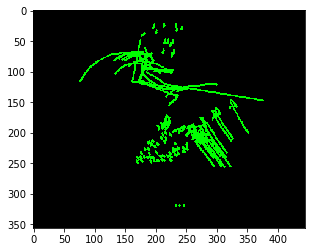

(<matplotlib.image.AxesImage at 0x25ac2a5a908>, None)

In [312]:
plt.imshow(mask),plt.show()

In [190]:
# save the image
plt.imsave(os.path.join(project_path, 'test.png'), mask)